In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from resources.plotting import Plotter
from tqdm.autonotebook import tqdm

from nltk.tokenize import WordPunctTokenizer

from rouge_score.rouge_scorer import RougeScorer
from resources.bart_score import BARTScorer
from resources.testing import PearsonCorrelationTester
from sklearn.metrics import f1_score, precision_score, recall_score

/tmp/ipykernel_1896527/3568371427.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
MODELS = {
    "Gemma - 2B":   "google/gemma-1.1-2b-it",
    "Gemma - 7B":   "google/gemma-1.1-7b-it",
    "Llama 3 - 8B": "meta-llama/Meta-Llama-3-8B-Instruct",
}

PLOTS_DIR  = "plots"

# Load results:

In [3]:
RESULTS = {}

for key in MODELS:
    with open(f'results/movies/{MODELS[key]}.pkl', 'rb') as file:
        RESULTS[key] = pickle.load(file)

In [4]:
pearson = PearsonCorrelationTester()
plotter = Plotter(RESULTS, i_sample=6, save_dir=PLOTS_DIR)
plotter.print_chat("Llama 3 - 8B")

\begin{tabular}{p{.05\linewidth}p{.1\linewidth}p{.8\linewidth}}

\hline

&
\textbf{user}: &
\texttt{What is the sentiment of the following review?

"Hints are made to the audience that this film could be a blast. Alas, these are only hints."

Assign one of the following labels: "negative" or "positive". Make sure to answer only with the label.} \\

&
\textbf{assistant}: &
\texttt{negative} \\


\hline

&
\textbf{user}: &
\texttt{What is the most important phrase of the review influencing your assessment? Provide only the phrase as a string.} \\

&
\textbf{assistant}: &
\texttt{"Alas, these are only hints."} \\


\hline

&
\textbf{user}: &
\texttt{Provide a version of the review that would flip your assessment while changing as few words in the original review as possible. Make sure to answer with only the new version.} \\

&
\textbf{assistant}: &
\texttt{"Hints are made to the audience that this film could be a blast. And indeed, these are more than just hints."} \\


\hline

\end{tabu

# Performance:

In [5]:
for model in RESULTS:
    y_true = np.array([(item['label']['text'] == 'positive', item['label']['text'] == 'negative') for item in RESULTS[model]], dtype=float)
    y_pred = np.array([(item['prediction']['text'] == 'positive', item['prediction']['text'] == 'negative') for item in RESULTS[model]], dtype=float)

    print(model)
    print('  F1:       ', f1_score(y_true, y_pred, average='macro'))
    print('  precision:', precision_score(y_true, y_pred, average='macro'))
    print('  recall:   ', recall_score(y_true, y_pred, average='macro'))
    print()

Gemma - 2B
  F1:        0.8949973749343734
  precision: 0.8950395039503951
  recall:    0.895

Gemma - 7B
  F1:        0.9149468417761101
  precision: 0.9160401002506267
  recall:    0.915

Llama 3 - 8B
  F1:        0.9549898727213624
  precision: 0.9554098688819939
  recall:    0.955



# Faithfullness:

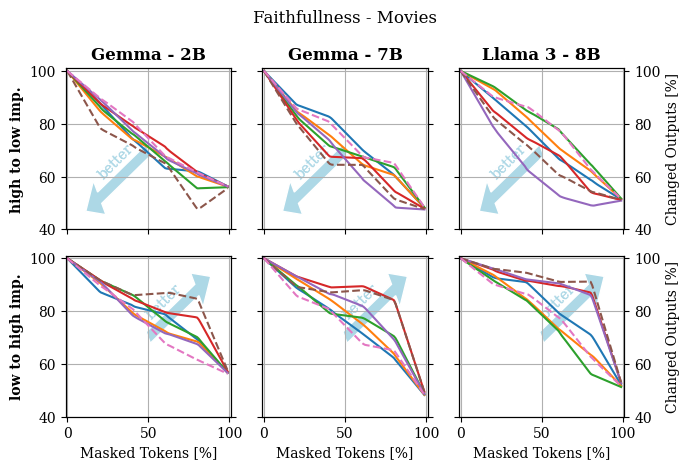

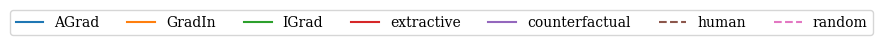

In [6]:
plotter.plot_perturbation(f'Faithfullness - Movies', bottom=.4)

Gemma - 2B

In [7]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma - 2B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['negative<eos>', '762'],
       ['positive<eos>', '438']], dtype='<U21')

Gemma - 7B

In [8]:
len(RESULTS['Gemma - 7B'])

200

In [9]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'].split('\n\n')[0].strip('"*.').lower() for r in RESULTS["Gemma - 7B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['positive<eos>', '1200']], dtype='<U21')

Llama 3 - 8B

In [10]:
np.array(np.unique(
    [r['perturbation'][key]['low2high'][-1]['s'] for r in RESULTS["Llama 3 - 8B"] for key in r['perturbation']],
    return_counts=True
)).T

array([['negative<|eot_id|>', '1146'],
       ['positive<|eot_id|>', '54']], dtype='<U21')

# Self assessment:

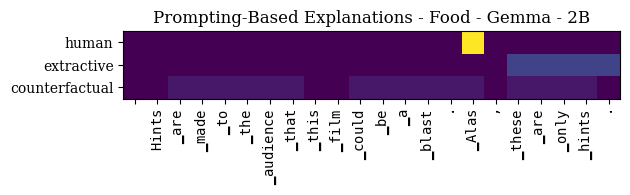

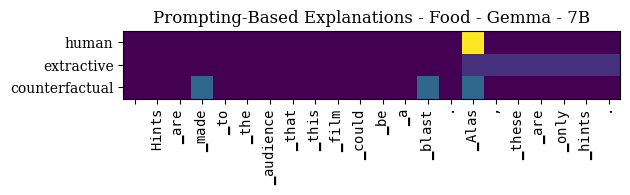

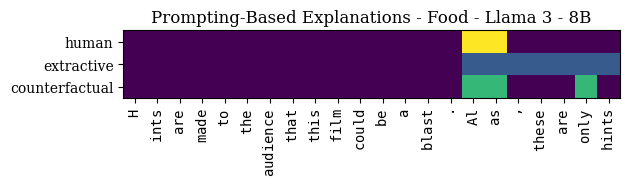

In [12]:
importance_human = {model:[] for model in RESULTS}
importance_self  = {model:[] for model in RESULTS}
importance_cf    = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        length = r['sample']['end'] - r['sample']['start']
        offset = r['sample']['start']
        
        importance_human[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['human']: 
            importance_human[model][-1][i-offset:j-offset] = 1.
        importance_human[model][-1] /= max(importance_human[model][-1].sum(), 1e-9)
        
        importance_self[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['extractive'][:len(r['spans']['human'])]:
            importance_self[model][-1][i-offset:j-offset] = 1.
        importance_self[model][-1] /= max(importance_self[model][-1].sum(), 1e-9)
        
        importance_cf[model].append(np.zeros(length, dtype=float))
        for i,j in r['spans']['counterfactual']:
            importance_cf[model][-1][i-offset:j-offset] = 1.
        importance_cf[model][-1] /= max(importance_cf[model][-1].sum(), 1e-9)

plotter.plot_importance([importance_human, importance_self, importance_cf], ['human', 'extractive', 'counterfactual'], f'Prompting-Based Explanations - Food')
pearson.add(importance_human, 'human')
pearson.add(importance_self,  'extractive')
pearson.add(importance_cf,    'counterfactual')

# AGrad:

Gemma - 2B 0.9220633597445314
Gemma - 7B 0.9897763022583717
Llama 3 - 8B 0.14194889700307273


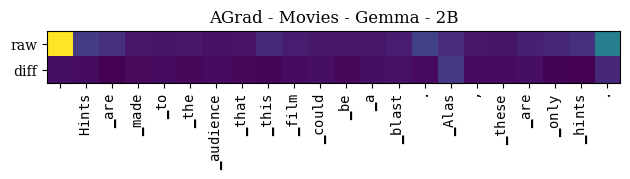

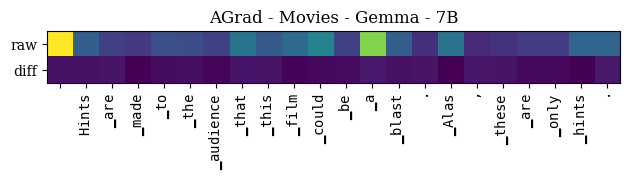

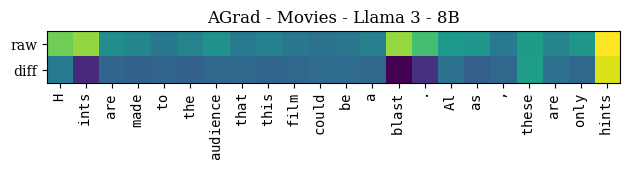

In [13]:
importance_agrad_pos  = {model:[] for model in RESULTS}
importance_agrad_neg  = {model:[] for model in RESULTS}
importance_agrad_diff = {model:[] for model in RESULTS}
importance_agrad      = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']
    
        # get prediction boundaries:
        y_start = r['prediction']['index'] - 1 # outputs are shifted by one!
        y       = r['prediction']['text'] == 'positive'
    
        pos  = r['AGrad'][0, 1, :, y_start, x_start:x_end]
        neg  = r['AGrad'][0, 0, :, y_start, x_start:x_end]
        
        importance_agrad_pos[model].append(pos.mean(axis=0))
        importance_agrad_neg[model].append(neg.mean(axis=0))
        importance_agrad_diff[model].append((pos - neg).mean(axis=0) * (1. if y else -1.))
        importance_agrad[model].append(np.abs(pos if y else neg).mean(axis=0))

    print(model, np.nanmean(pearson.correlate(importance_agrad_pos[model], importance_agrad_neg[model])[0]))

plotter.plot_importance([importance_agrad, importance_agrad_diff], ['raw', 'diff'], f'AGrad - Movies')
pearson.add(importance_agrad, 'AGrad')

# GradIn

Gemma - 2B 0.5669488919822137
Gemma - 7B 0.9889550833084482
Llama 3 - 8B 0.4414140042163634


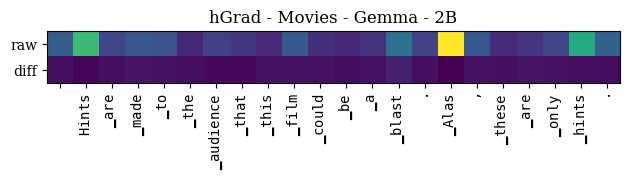

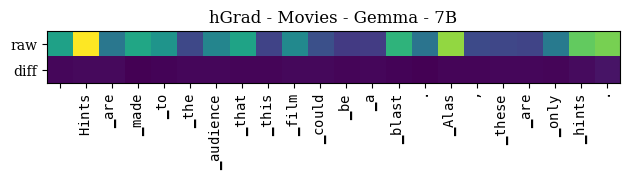

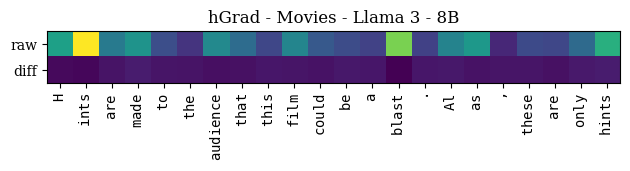

In [14]:
importance_gradin_pos  = {model:[] for model in RESULTS}
importance_gradin_neg  = {model:[] for model in RESULTS}
importance_gradin_diff = {model:[] for model in RESULTS}
importance_gradin      = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']
    
        # get prediction:
        y       = r['prediction']['text'] == 'positive'
        
        pos  = r['GradIn'][0, 1, x_start:x_end, :]
        neg  = r['GradIn'][0, 0, x_start:x_end, :]
        
        importance_gradin_pos[model].append(pos.mean(axis=-1).T)
        importance_gradin_neg[model].append(neg.mean(axis=-1).T)
        importance_gradin_diff[model].append((pos - neg).mean(axis=-1).T * (1. if y else -1.))
        importance_gradin[model].append(np.abs(pos if y else neg).mean(axis=-1).T)

    print(model, np.nanmean(pearson.correlate(importance_gradin_pos[model], importance_gradin_neg[model])[0]))

plotter.plot_importance([importance_gradin, importance_gradin_diff], ['raw', 'diff'], f'hGrad - Movies')
pearson.add(importance_gradin, 'GradIn')

# Grad$^{-1}$

Gemma - 2B -0.5976563520327542
Gemma - 7B -0.9526979053463944
Llama 3 - 8B -0.308944237099374


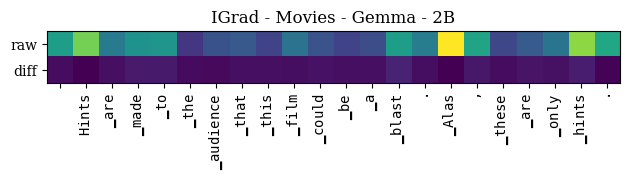

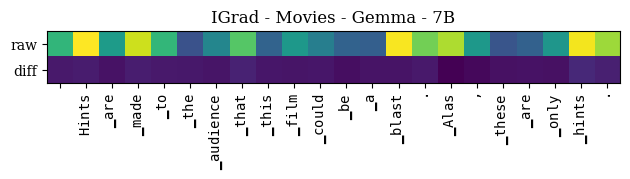

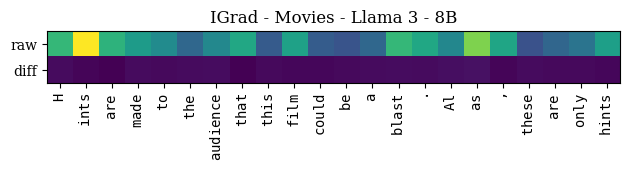

In [15]:
importance_igrad_pos  = {model:[] for model in RESULTS}
importance_igrad_neg  = {model:[] for model in RESULTS}
importance_igrad_diff = {model:[] for model in RESULTS}
importance_igrad      = {model:[] for model in RESULTS}

for model in RESULTS:
    for r in RESULTS[model]:
        # get sample boundaries:
        x_start = r['sample']['start']
        x_end   = r['sample']['end']
    
        # get prediction:
        y       = r['prediction']['text'] == 'positive'
    
        pos  = r['IGrad'][0, x_start:x_end, :, 1]
        neg  = r['IGrad'][0, x_start:x_end, :, 0]
        
        importance_igrad_pos[model].append(pos.mean(axis=-1).T)
        importance_igrad_neg[model].append(neg.mean(axis=-1).T)
        importance_igrad_diff[model].append((pos - neg).mean(axis=-1).T * (1. if y else -1.))
        importance_igrad[model].append(np.abs(pos if y else neg).mean(axis=-1).T)

    print(model, np.nanmean(pearson.correlate(importance_igrad_pos[model], importance_igrad_neg[model])[0]))

plotter.plot_importance([importance_igrad, importance_igrad_diff], ['raw', 'diff'], f'IGrad - Movies')
pearson.add(importance_igrad, 'IGrad')

# Correlations:

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


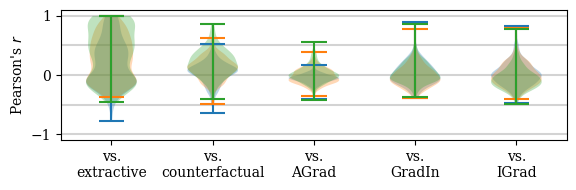

[<matplotlib.patches.Patch object at 0x7f1f39e6bbe0>, <matplotlib.patches.Patch object at 0x7f1f39e551e0>, <matplotlib.patches.Patch object at 0x7f1f39e57280>]


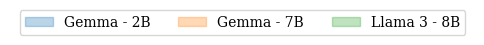

In [16]:
pearson.boxplot('human', path=f'{PLOTS_DIR}/PearsonViolin - Movies - Human.pdf')

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


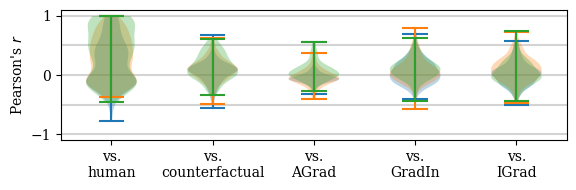

[<matplotlib.patches.Patch object at 0x7f1f5164ddb0>, <matplotlib.patches.Patch object at 0x7f1f51795e10>, <matplotlib.patches.Patch object at 0x7f1f5164f3d0>]


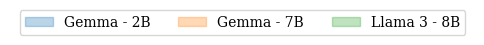

In [17]:
pearson.boxplot('extractive', path=f'{PLOTS_DIR}/PearsonViolin - Movies - Self.pdf')

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


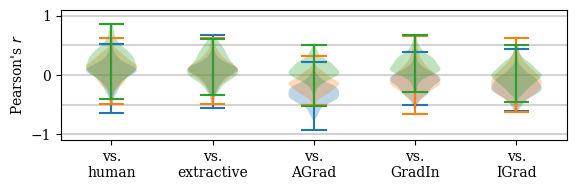

[<matplotlib.patches.Patch object at 0x7f1f51664a60>, <matplotlib.patches.Patch object at 0x7f1f51796050>, <matplotlib.patches.Patch object at 0x7f1f517b5ba0>]


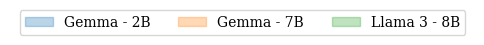

In [18]:
pearson.boxplot('counterfactual', path=f'{PLOTS_DIR}/PearsonViolin - Movies - Counterfactual.pdf')

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


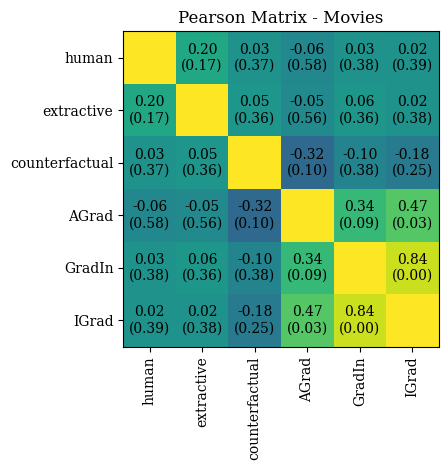

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


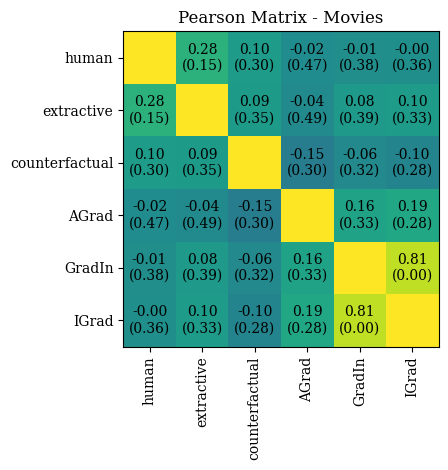

/home/h21/kora8563/explainability/resources/testing.py:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r[i], p[i] = pearsonr(x, y)


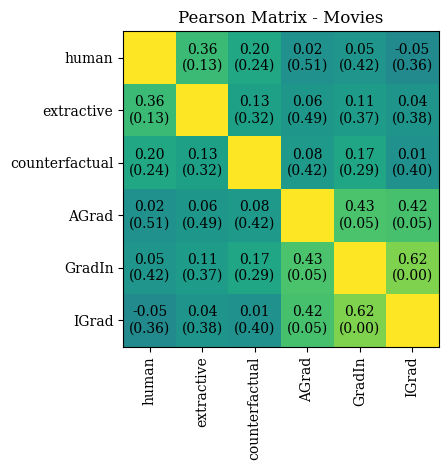

In [19]:
pearson.matrixplot(title='Pearson Matrix - Movies', dir=PLOTS_DIR)

# Gradient Saturation:

Gemma - 2B
  mean: 4.84463872584842e-07
  std:  0.0005092528536409514
  min:  -0.0144329833984375
  max:  0.013526153564453126

Gemma - 7B
  mean: 1.0779283174932399e-05
  std:  0.006365961112162619
  min:  -0.306103515625
  max:  0.229315185546875

Llama 3 - 8B
  mean: -3.554762027794515e-05
  std:  0.029228240064572825
  min:  -1.0841845703125
  max:  0.825546875



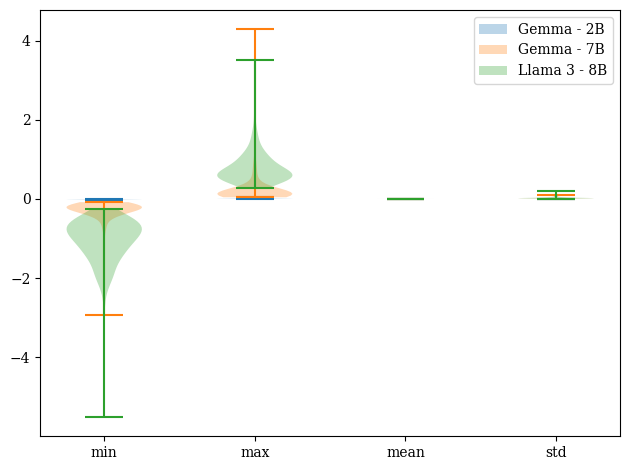

In [20]:
hs, ls = [], [] 
for model in RESULTS:
    grad_min = []
    grad_avg = []
    grad_std = []
    grad_max = []
    
    for r in RESULTS[model]:
        # get sample boundaries:
        start = r['sample']['start']
        end   = r['sample']['end']

        # get important window:
        grad = r['Grad'][0, :, start:end, :]

        grad_min.append(grad.min())
        grad_avg.append(grad.mean())
        grad_std.append(grad.std())
        grad_max.append(grad.max())
   
    hs.append(plt.violinplot([grad_min, grad_max, grad_avg, grad_std])['bodies'][0])
    ls.append(model)

    print(model)
    print('  mean:', np.mean(grad_avg))
    print('  std: ', np.mean(grad_std))
    print('  min: ', np.mean(grad_min))
    print('  max: ', np.mean(grad_max))
    print()

plt.xticks(ticks=[1, 2, 3, 4], labels=['min', 'max', 'mean', 'std'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()

# Counterfactual:

/home/h21/kora8563/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Gemma - 2B
  Success rate: 0.235
  Similarity: 0.6256860673339466
  ROUGE-1: 0.3374934895071899
  BLEU-1: 0.50415954307732
  ROUGE-L: 0.3021777595603572
  BART: -3.0161231223573077

Gemma - 7B
  Success rate: 0.84
  Similarity: 0.6524572992904822
  ROUGE-1: 0.4519223346582079
  BLEU-1: 0.5675487332174807
  ROUGE-L: 0.4183259255533803
  BART: -2.756012041653906

Llama 3 - 8B
  Success rate: 0.94
  Similarity: 0.857009285061563
  ROUGE-1: 0.8158913527196962
  BLEU-1: 0.8227086081182765
  ROUGE-L: 0.8078884416726169
  BART: -1.6857623625943001



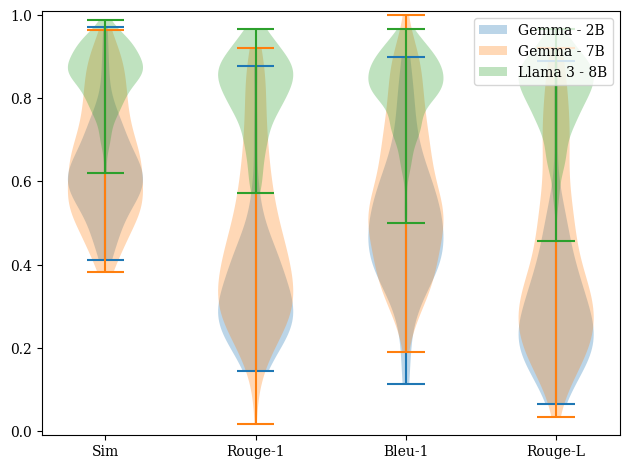

In [21]:
rouge_scorer = RougeScorer(['rouge1', 'rougeL'], tokenizer=WordPunctTokenizer())
bart_scorer = BARTScorer(device='cuda:0', checkpoint='facebook/bart-large-cnn')

hs, ls = [], [] 
for model in RESULTS:
    counterfactuals = []

    for r in RESULTS[model]:
        cf = r['counterfactual']
        success = cf['prediction'] != r['prediction']['text']
    
        rouge = rouge_scorer.score(r['sample']['text'].lower(), cf['text'].lower())
        bart = bart_scorer.score([r['sample']['text']], [cf['text'].lower()], batch_size=4)
        
        counterfactuals.append((
            int(success),
            cf['similarity'],
            rouge['rouge1'].recall,    # rouge
            rouge['rouge1'].precision, # bleu
            rouge['rougeL'].fmeasure,
            bart[0]
        ))
    
    counterfactuals = np.array(counterfactuals, dtype=float)

    hs.append(plt.violinplot(counterfactuals[counterfactuals[:,0] == 1., 1:-1])['bodies'][0])
    ls.append(model)

    print(model)
    print('  Success rate:', counterfactuals[:,0].mean())
    print('  Similarity:', counterfactuals[counterfactuals[:,0] == 1., 1].mean())
    print('  ROUGE-1:', counterfactuals[counterfactuals[:,0] == 1., 2].mean())
    print('  BLEU-1:', counterfactuals[counterfactuals[:,0] == 1., 3].mean())
    print('  ROUGE-L:', counterfactuals[counterfactuals[:,0] == 1., 4].mean())
    print('  BART:', counterfactuals[counterfactuals[:,0] == 1., 5].mean())
    print()

plt.ylim(bottom=-.01, top=1.01)
plt.xticks(ticks=[1, 2, 3, 4], labels=['Sim', 'Rouge-1', 'Bleu-1', 'Rouge-L'])
plt.legend(handles=hs, labels=ls)
plt.tight_layout()
plt.show()